In [7]:
import numpy as np
import math as mat
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
import imageio
#%matplotlib notebook
#from sympy import *
#plt.rcParams['figure.figsize']=(5,3)
#plt.rcParams['figure.dpi'] = 150

In [8]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))


def dsigmoid(x):
    y = sigmoid(x)
    return y * (1. - y)


def dtanh(x):
    return 1. - np.tanh(x) ** 2


def lrelu(x, alpha=1e-2):
    return np.maximum(x, x * alpha)


def dlrelu(x, alpha=1e-2):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx


### Unimodal Data Generation

In [9]:
#Data Generation

m = 2000
#X = np.random.normal(0,1,size=[m, 1])
X = np.random.uniform(0,1,(m, 1))

#dataset = np.random.beta(0.5,0.5, size=[m,1])
#dataset = np.tanh(-5*lrelu(1*X+0)-5*lrelu(-1*X+0)+2)

dataset = np.random.normal(10,1,size=[m,1])

#dataset = 5* lrelu(1*X - 0.6) - 5*lrelu(-1*X + 0.4) + 10

#dataset = 8*lrelu(1*X - 0.7,0) - 8*lrelu(-1*X + 0.3,0) + 10

#dataset = -3.5*lrelu(1*X-0.5,0) - 3.5*lrelu(0.5-1*X,0) + 3.5*lrelu(-2*X+0.5,0) 

#dataset =  10/9* lrelu(1*X - 0.55,0) - 10/9*lrelu(-1*X + 0.45,0) + 2.5*lrelu(1*X - 0.8,0) - 2.5*lrelu(-1*X + 0.2,0)


def NormOnData(X):
    return (X - np.min(dataset))/(np.max(dataset)-np.min(dataset) + 1e-8)

def dNormOnData(X):
    return 1/(np.max(dataset)-np.min(dataset) + 1e-8)

def NormOnDataset2(X):
    return (np.max(dataset)-np.min(dataset))*(X-np.min(X))/(np.max(X)-np.min(X) + 1e-8) + np.min(dataset)


def dNormOnDataset(X):
    return (np.max(dataset)-np.min(dataset))/(np.max(X)-np.min(X) + 1e-8) 


def MinMaxN(X):
    return (X-np.min(X))/(np.max(X)-np.min(X) + 1e-8)


def dMinMaxN(X):
    return 1/(np.max(X)-np.min(X)+1e-8)



### Multimodal Data Generation

In [105]:
m = 2000
cluster1 = np.random.normal(0,1, size=[3*m//4,1])
cluster2 = np.random.normal(5,1, size=[m//4,1])

dataset = np.concatenate((cluster1,cluster2))



### Data visualization

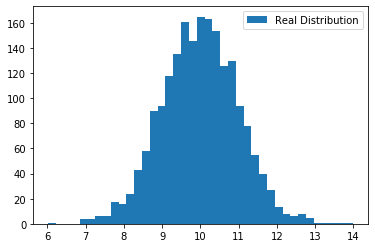

In [10]:
#Data set visualization
plt.hist(dataset, bins='auto', label='Real Distribution')
plt.legend(loc='upper right')
plt.show()

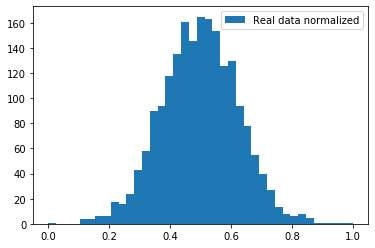

In [11]:
#Normalized Data visualization
plt.hist(MinMaxN(dataset), bins='auto', label='Real data normalized')
plt.legend(loc='upper right')
plt.show()

In [12]:
def initiate_parameters(nx_g, nh_g, inp_size, nh_d):
        # -------- Generator --------#
    W0_g = np.random.randn(nx_g, nh_g)* np.sqrt(2./nx_g)
    #W0_g = np.random.randn(nx_g, nh_g)
    b0_g = np.zeros((1, nh_g))
    #b0_g = np.random.normal(0,1,(1, nh_g))
    #b0_b = np.array([[2,-9]])

    W1_g = np.random.randn(nh_g, inp_size)* np.sqrt(2. / nh_g)
    #W1_g = np.random.randn(nh_g, inp_size)
    b1_g = np.zeros((1, inp_size))
    #b1_g = np.random.normal(0,1,(1, inp_size))


    W_g = [W0_g, W1_g]
    b_g = [b0_g, b1_g]

    # -------- Discriminator --------#
    W0_d = np.random.randn(inp_size, nh_d)* np.sqrt(2. / inp_size) 
    #W0_d = np.random.randn(inp_size, nh_d)
    #b0_d = np.random.randn(1, nh_d)
    b0_d = np.zeros((1,nh_d))

    W1_d = np.random.randn(nh_d, 1)* np.sqrt(2. / nh_d)
    #W1_d = np.random.randn(nh_d, 1)
    #b1_d = np.random.randn(1, 1)
    b1_d = np.zeros((1, 1))
    
    """
    W0_g = np.random.randn(nx_g, nh_g) * np.sqrt(2. / nx_g)
    b0_g = np.zeros((1, nh_g))

    W1_g = np.random.randn(nh_g, inp_size) * np.sqrt(2. / nh_g)  
    b1_g = np.zeros((1, inp_size))

    W_g = [W0_g, W1_g]
    b_g = [b0_g, b1_g]

    # -------- Discriminator --------#
    W0_d = np.random.randn(inp_size, nh_d) * np.sqrt(2. / inp_size)
    b0_d = np.zeros((1, nh_d))

    W1_d = np.random.randn(nh_d, 1) * np.sqrt(2. / nh_d)
    b1_d = np.zeros((1, 1))
    """
    
    W_d = [W0_d, W1_d]
    b_d = [b0_d, b1_d]

    return W_g, b_g, W_d, b_d

In [45]:
def forward_generator(z, W_g, b_g):
    z_g = []
    a_g = []
    
    z0_g = np.dot(z, W_g[0]) + b_g[0]
    z_g.append(z0_g)
    #a0_g = sigmoid(z0_g)
    a0_g = lrelu(z0_g)
    a_g.append(a0_g)

    z1_g = np.dot(a0_g, W_g[1]) + b_g[1]
    z_g.append(z1_g)
    
    #a1_g = MinMaxN(z1_g)
    #a1_g = NormOnData(z1_g)
    #a1_g = np.tanh(z1_g)
    #a1_g = lrelu(z1_g)
    a1_g = sigmoid(z1_g)
    #a1_g = z1_g
    a_g.append(a1_g)
    return z_g, a_g


def forward_discriminator(x, W_d, b_d):
    z_d = []
    a_d = []
    
    z0_d = np.dot(x, W_d[0]) + b_d[0]
    z_d.append(z0_d)
    #a0_d = sigmoid(z0_d)
    a0_d = lrelu(z0_d)
    a_d.append(a0_d)

    z1_d = np.dot(a0_d, W_d[1]) + b_d[1]
    z_d.append(z1_d)
    a1_d = sigmoid(z1_d)  # check: output probability between [0,1]
    a_d.append(a1_d)
    return z_d, a_d

In [14]:
def preprocess_data(x, batch_size):
     
    
    x_train = np.reshape(x, (len(x),-1))
    x_train = MinMaxN(x_train)

    # limit the data to full batches only
    num_batches = x_train.shape[0] // batch_size
    x_train = x_train[: num_batches * batch_size]
    #x_train = MinMaxN(x_train)

    # normalise the data to the range [-1,1] = [a,b]
    # X' = a + (b-a)(X-Xmin)/(Xmax-Xmin)
    #x_train = -1+2*(x_train-x_train.min())/(x_train.max()-x_train.min())

    # shuffle the data
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    return x_train, num_batches

In [15]:
def backpropagation_D(x_real, a_real, z_real, x_fake, a_fake, z_fake, W_d, der_activation):
    
    a1_real = a_real[-1]
    a0_dr = a_real[0]
    z1_real = z_real[-1]
    z0_dr = z_real[0]
    
    a1_fake = a_fake[-1]
    a0_df = a_fake[0]
    z1_fake = z_fake[-1]
    z0_df = z_fake[0]
       
    # cost_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))
    #real input cost derivative = (-np.log(a1_real))' = -1/a1_real
        
    da1_real = -1. / (a1_real + 1e-8)

    dz1_real = da1_real * dsigmoid(z1_real)
    dW1_real = np.dot(a0_dr.T, dz1_real)
    db1_real = np.sum(dz1_real, axis=0, keepdims=True)

    da0_real = np.dot(dz1_real, W_d[1].T)
    dz0_real = da0_real * der_activation(z0_dr)    
    dW0_real = np.dot(x_real.T, dz0_real)
    db0_real = np.sum(dz0_real, axis=0, keepdims=True)
        
    # fake input cost derivative =  (-np.log(1 - a1_fake))' = 1/(1-a1_fake)
    da1_fake = 1. / (1. - a1_fake + 1e-8)

    dz1_fake = da1_fake * dsigmoid(z1_fake)
    dW1_fake = np.dot(a0_df.T, dz1_fake)
    db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

    da0_fake = np.dot(dz1_fake, W_d[1].T)
    dz0_fake = da0_fake * der_activation(z0_df)
    dW0_fake = np.dot(x_fake.T, dz0_fake)
    db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

    # -------- Combine gradients for real & fake images--------#
    dW1 = (dW1_real + dW1_fake)
    db1 = (db1_real + db1_fake)

    dW0 = (dW0_real + dW0_fake)
    db0 = (db0_real + db0_fake)
    
    #dW0 = np.nan_to_num(dW0)
    #db0 = np.nan_to_num(db0)
    #dW1 = np.nan_to_num(dW1)
    #db1 = np.nan_to_num(db1)
    
    return dW0, db0, dW1, db1

In [16]:
def backpropagation_G(z, a_d, z_d, a_g, z_g, W_d, W_g, der_activation_D, der_activation_G):
              
    a1_fake = a_d[-1]
    z1_fake = z_d[-1]
    z0_d = z_d[0]
    
    z1_g = z_g[-1]
    a0_g = a_g[0]
    z0_g = z_g[0]

    # -------- Backprop through Discriminator --------#
    # cost_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))

    # fake input as real -> cost derivative = (-np.log(a1_fake))' = -1/a1_fake
    da1_d = -1.0 / (a1_fake + 1e-8)  # 64x1

    dz1_d = da1_d * dsigmoid(z1_fake)
    da0_d = np.dot(dz1_d, W_d[1].T)
    dz0_d = da0_d * der_activation_D(z0_d)
    dx_d = np.dot(dz0_d, W_d[0].T)

    # -------- Backprop through Generator --------#
    # cost_G = np.mean(-np.log(1 - a1_fake))
    # fake input cost derivative = (-np.log(1 - a1_fake))' = 1/(1-a1_fake)
    
    #dz1_g = dx_d
    dz1_g = dx_d * dsigmoid(z1_g)
    #dz1_g = dx_d * dtanh(z1_g)
    #dz1_g = dx_d * dlrelu(z1_g)
    #dz1_g = dx_d * dMinMaxN(z1_g)
    #dz1_g = dx_d * dNormOnData(z1_g)
    dW1_g = np.dot(a0_g.T, dz1_g)
    db1_g = np.sum(dz1_g, axis=0, keepdims=True)
    #db1_g = 0

    da0_g = np.dot(dz1_g, W_g[1].T)
    dz0_g = da0_g * der_activation_G(z0_g)
    dW0_g = np.dot(z.T, dz0_g)
    db0_g = np.sum(dz0_g, axis=0, keepdims=True)
    
    #dW0_g = np.nan_to_num(dW0_g)
    #db0_g = np.nan_to_num(db0_g)
    #dW1_g = np.nan_to_num(dW1_g)
    #db1_g = np.nan_to_num(db1_g)
    
    return dW0_g, db0_g, dW1_g, db1_g

In [129]:
  
J_Ds = []  # stores the disciminator losses
J_Gs = []  # stores the generator losses
    
epochs = 50
batch_size = 100
nx_g = 30#input_layer_size_g
nh_g = 80 #hidden_layer_size_g
nh_d = 80 #hidden_layer_size_d
#input_layer_d = inp_size
#output_layer_d = 1
#output_layer_g = inp_size

lr = 3e-3 #learning_rate
dr = 0e-5 #decay_rate
inp_size = len(dataset[0])

#preprocess input -note that labels aren't needed
x_train, num_batches = preprocess_data(dataset, batch_size)
    
    # -------- Initialise weights with Xavier method --------#

W_g, b_g, W_d, b_d = initiate_parameters(nx_g, nh_g, inp_size, nh_d)
    
W_d_track = [W_d]
b_d_track = [b_d]
W_g_track = [W_g]
b_g_track = [b_g]
x_fake_track = []
dW_track = []

dW0_d_track = []
dW1_d_track = []
db0_d_track = []
db1_d_track = []

dW0_g_track = []
dW1_g_track = []
db0_g_track = []
db1_g_track = []

for epoch in range(1,epochs):
    #lr = 1/(50*epoch)
    lrG = 1*lr
    for i in range(num_batches):
            
        # ------- PREPARE INPUT BATCHES & NOISE -------#
        x_real = x_train[i * batch_size: (i + 1) * batch_size]
        #x_real = MinMaxN(x_real)
        #z = np.random.normal(0,1, size=[batch_size, nx_g])
        z = np.random.uniform(0,1, (batch_size, nx_g))
            
        # ------- FORWARD PROPAGATION -------#
        #b_g[1][0][0]=0
        z_g, a_g = forward_generator(z, W_g, b_g)
        x_fake = a_g[-1]
        z_d_real, a_d_real = forward_discriminator(x_real, W_d, b_d)
        z_d_fake, a_d_fake = forward_discriminator(x_fake, W_d, b_d)
            
        

        # ------- CROSS ENTROPY LOSS -------#
        # ver1 : max log(D(x)) + log(1 - D(G(z))) (in original paper)
        # ver2 : min -log(D(x)) min log(1 - D(G(z))) (implemented here)
        J_D = np.mean(-np.log(a_d_real[-1]) - np.log(1 - a_d_fake[-1]))
        J_Ds.append(J_D)

        # ver1 : minimize log(1 - D(G(z))) (in original paper)
        # ver2 : maximize log(D(G(z)))
        # ver3 : minimize -log(D(G(z))) (implemented here)
        J_G = np.mean(-np.log(a_d_fake[-1]))
        J_Gs.append(J_G)
        
        
    
        # Discriminator backpropagation
        dW0, db0, dW1, db1 = backpropagation_D(x_real, a_d_real, z_d_real, x_fake, a_d_fake, z_d_fake, W_d, dlrelu)
        
        
        # D Parameter's update
        W_d = [W_d[0] - lr * dW0, W_d[1] - lr * dW1]
        b_d = [b_d[0] - lr * db0, b_d[1] - lr * db1]
        
        
        # Generator backpropagation
        dW0_g, db0_g, dW1_g, db1_g = backpropagation_G(z, a_d_fake, z_d_fake, a_g, z_g, W_d, W_g, dlrelu, dlrelu)
        

        # G Parameter's update
        W_g = [W_g[0] - lrG * dW0_g, W_g[1] - lrG * dW1_g]
        b_g = [b_g[0] - lrG * db0_g, b_g[1] - lrG * db1_g]


    if epoch%10 == 1:
        W_d_track.append(W_d)
        b_d_track.append(b_d)
        W_g_track.append(W_g)
        b_g_track.append(b_g)
        x_fake_track.append(x_fake)
        dW_track.append(dW1)
        
        dW0_d_track.append(dW0)
        dW1_d_track.append(dW1)
        db0_d_track.append(db0)
        db1_d_track.append(db1)

        dW0_g_track.append(dW0_g)
        dW1_g_track.append(dW1_g)
        db0_g_track.append(db0_g)
        db1_g_track.append(db1_g)

        
        
    # reduce learning rate after every epoch
    lr = lr * (1.0 / (1.0 + dr * epoch))

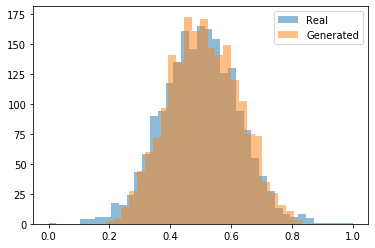

In [130]:
#z = np.random.normal(0, 1, size=[1000, 1])
z = np.random.uniform(0,1, (m, nx_g))
gen_samples, gen_samplesN = forward_generator(z, W_g, b_g)

#plt.hist(datasetN, bins = 'auto', alpha=0.5, label='Real')
plt.hist(MinMaxN(dataset), bins = 'auto', alpha=0.5, label='Real')
plt.hist(gen_samplesN[-1], bins = 'auto', alpha=0.5, label='Generated')
plt.legend(loc='upper right')
plt.show()

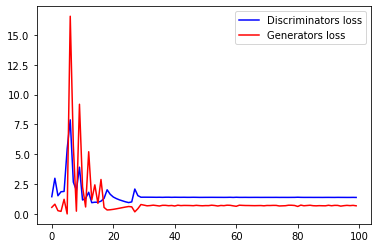

In [133]:
plt.plot(J_Ds[:100], 'b', label='Discriminators loss')
plt.plot(J_Gs[:100], 'r', label = 'Generators loss')
plt.legend()
plt.show()

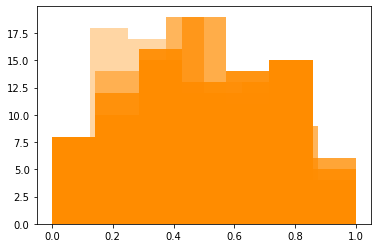

In [102]:
#Generated distribution

for i in range(len(x_fake_track)):
    a = (i+5)/(len(x_fake_track)+4)
    plt.hist(x_fake_track[i], bins = 'auto', alpha=a, color='darkorange')

#plt.hist(MinMaxNorm(dataset), bins = 'auto', alpha=0.5, label='Real')
#plt.legend()º
plt.show()

(array([ 4., 18., 17., 11.,  8.,  4.,  1.,  1.]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 <a list of 8 Patch objects>)

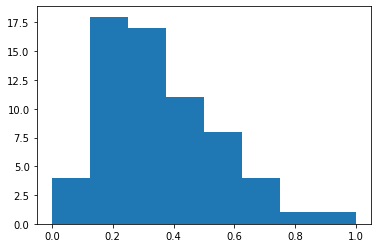

In [103]:
plt.hist(x_fake_track[0], bins = 'auto')

## Weights flow

### Discriminator
Size of the input = 1

Size of the output = 1

The hidden node $j$ is ploted as a pair of cordinates: 
$$ \big(\theta_1(j), \theta_2(j) \big) $$

$ \quad \theta_1(j) - $ weight that comes in the node $j$ (from the single input node)

$ \quad \theta_2(j) - $ weight that comes out of the node $j$ (to the single output node)

<IPython.core.display.Javascript object>


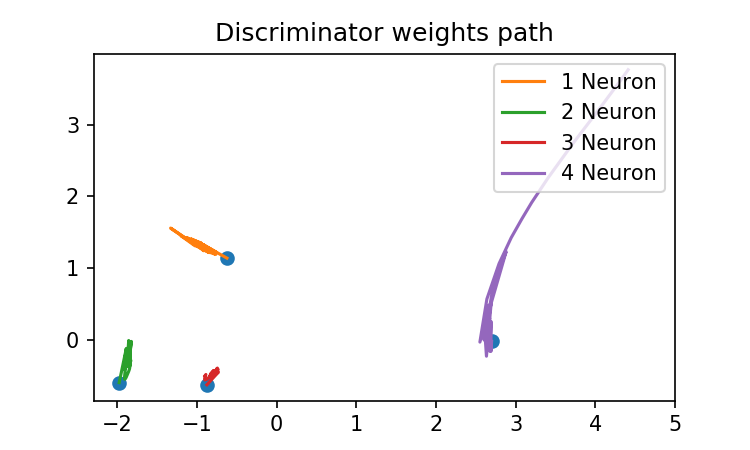

In [88]:
plt.plot(W_d_track[0][0][0],W_d_track[0][1].T[0], 'o')


for i in range(nh_d):
    n=i+1
    plt.plot([w[0][0][i] for w in W_d_track],[w[1][i][0] for w in W_d_track],  label='%s Neuron' % n)

plt.xlim(right = 5)
plt.title('Discriminator weights path')
plt.legend(loc ='upper right')
plt.show()


### Generator - 2D (no bias)

Size of the output = 1

#### Size of the input = 1

Then, like in the Discriminator:


The hidden node $j$ is ploted as a pair of cordinates: 
$$ \big(\theta_1(j), \theta_2(j) \big) $$

$ \quad \theta_1(j) - $ weight that comes in the node $j$ (from the single input node)

$ \quad \theta_2(j) - $ weight that comes out of the node $j$ (to the single output node)

<IPython.core.display.Javascript object>


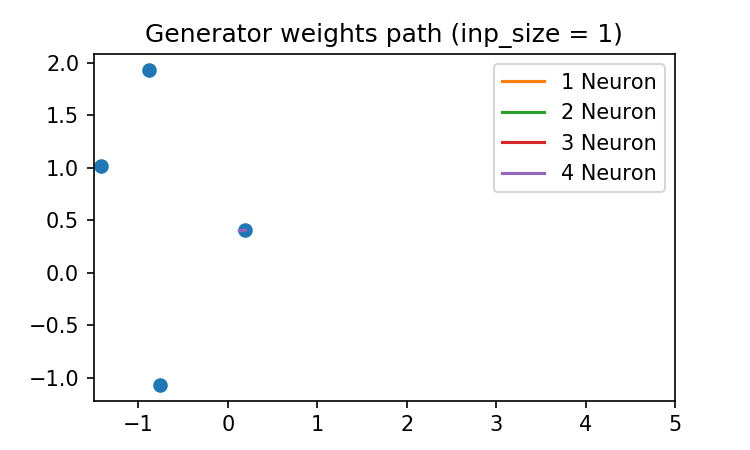

In [199]:
plt.plot(W_g_track[0][0][0],W_g_track[0][1].T[0], 'o')


for i in range(nh_g):
    n=i+1
    plt.plot([w[0][0][i] for w in W_g_track],[w[1][i][0] for w in W_g_track],  label='%s Neuron' % n)

plt.xlim(right = 5)
plt.title('Generator weights path (inp_size = 1)')
plt.legend(loc ='upper right')
plt.show()

#### Size of the input = 2
The hidden node $j$ is ploted as a vector 

$$ | \theta_2(j) | \Big(\theta_1(1,j), \theta_1(2,j) \Big)$$

$ \quad \theta_1(i,j) - $ weight that comes in the node $j$, from the input node $i = $ 1, 2

$ \quad \theta_2(j) - $ weight that comes out of the node $j$ (to the single output node)

In [36]:
plt.plot(W_g_track[0][0][0]*abs(W_g_track[0][1].T[0]),W_g_track[0][0][1]*abs(W_g_track[0][1].T[0]), 'o')


for i in range(nh_g):
    n=i+1
    plt.plot([w[0][0][i]*abs(w[1][i]) for w in W_g_track],[w[0][1][i]*abs(w[1][i]) for w in W_g_track], label='%s Neuron' % n)

plt.xlim(right = 5)
plt.title('Generator weights path (inp_size = 2)')
plt.legend(loc ='upper right')
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

### Generator - 3D (w, theta, bias)

Size of input = 1

If the objective funtion is
$$  h(x) = w_1*relu(\theta_1*x + b_1) + w_2*relu(\theta_2*x + b_2) + w_2*relu(\theta_2*x + b_2)$$

We plot in $\mathbb{R}^3$ the particles
    $$ (\theta_i, w_i, b_i) $$

<IPython.core.display.Javascript object>


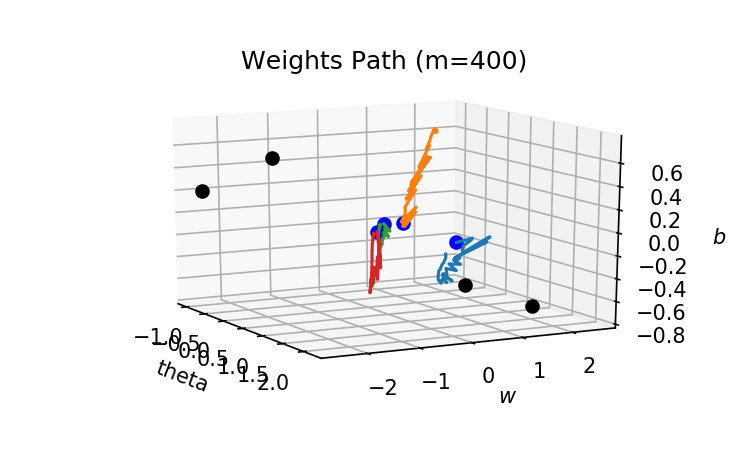

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(W_g_track[0][0][0],W_g_track[0][1].T[0], b_g_track[0][0][0], 'bo')
ax.plot([1,-1,1,-1],[10/9,-10/9,2.5,-2.5],[-0.55,0.45,-0.8,0.2], 'ko')


for i in range(nh_g):
    n=i+1
    ax.plot([w[0][0][i] for w in W_g_track],[w[1][i][0] for w in W_g_track], [b[0][0][i] for b in b_g_track], label='%s Neuron' % n)

ax.set_xlabel('theta')
ax.set_ylabel('$w$')
ax.set_zlabel('$b$')
#plt.xlim(right = 6)
#plt.ylim(right = 5)
plt.title('Weights Path (m=400)')
#plt.legend(loc ='upper right')
plt.show()

In [29]:
W_g_track[0][1]

array([[ 0.05230884],
       [ 0.02773911],
       [-0.03908068],
       [ 0.00134725],
       [-0.14969914],
       [-0.15498571],
       [-0.20742761],
       [-0.13496159],
       [-0.00431269],
       [ 0.0939244 ],
       [ 0.05053782],
       [-0.00335794],
       [-0.08940375],
       [ 0.01436054],
       [-0.05614348],
       [-0.06385546],
       [ 0.1302911 ],
       [-0.00724266],
       [ 0.06462445],
       [-0.12184489],
       [ 0.19646375],
       [-0.1488017 ],
       [ 0.02591975],
       [ 0.04316608],
       [-0.06188764],
       [-0.09393355],
       [-0.1303461 ],
       [-0.03927662],
       [-0.08044445],
       [-0.06465619],
       [ 0.033563  ],
       [ 0.17449973],
       [ 0.2154602 ],
       [-0.00491703],
       [ 0.03019818],
       [-0.03058316],
       [-0.01277835],
       [-0.17938658],
       [ 0.00306813],
       [ 0.09847944],
       [ 0.04934323],
       [-0.0433377 ],
       [ 0.05137628],
       [-0.01383784],
       [-0.12111318],
       [-0

In [128]:
x = np.arange(-1.,1,0.01)
x = x.reshape(len(x),1)
plt.plot(x, forward_discriminator(x,W_d, b_d)[1][-1])

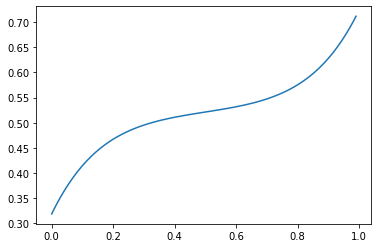

In [64]:
dataset = np.random.normal(10,1,size=[1,100])

def MinMaxNorm(X):
    return (X-np.min(dataset))/(np.max(dataset)-np.min(dataset) + 1e-8)

def G(x):
    return MinMaxNorm(10*sigmoid(7*x+2) + 10*sigmoid(7*x-9))

x=np.arange(0.,1.,0.01)
plt.plot(x,G(x))

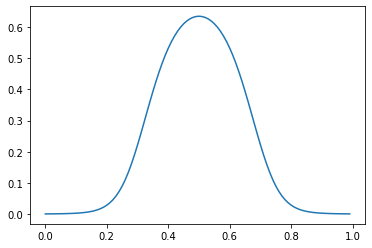

In [16]:
def D(x):
    return sigmoid(10*sigmoid(10*x-2) + 10*sigmoid(-10*x+ 8) -18.5)

x=np.arange(0.,1.,0.01)
plt.plot(x,D(x))